In [ ]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import os.path
from tqdm import tqdm
import pathlib
import imodelsx.llm
import json
import requests
import numpy as np
import openai
import pubmed
import paper_parsing
import prompts
openai.api_key = open('/home/chansingh/.OPENAI_KEY').read().strip()
plt.style.use('default')
dvu.set_style()

In [ ]:
df = pd.read_csv('../data/main.csv')

### Look at gender ratios

In [ ]:
idxs = (df['num_male_corrected'].notnull() & ~(df['num_male_corrected'] == 'Unk')) & (df['num_female_corrected'].notnull() & ~(df['num_female_corrected'] == 'Unk'))
male = df['num_male_corrected'][idxs].astype(int)
female = df['num_female_corrected'][idxs].astype(int)

In [ ]:
ratios = (male / female).values
# drop inf
print(sorted(ratios))

In [ ]:
plt.figure(figsize=(4, 2), dpi=300)
r = ratios[~np.isinf(ratios)]
r = r[r > 0]
logr = np.log10(r)
print(
    "mean",
    r.mean().round(2),
    'median',
    np.median(r).round(2),
    "frac>0",
    (r > 1).sum(),
    "/",
    len(r),
    "excluding",
    np.sum(np.isinf(ratios)),
    "all-male studies and",
    np.sum(ratios == 0),
    "all-female studies",
)
plt.hist(logr[logr < 0], color="pink")  # , bins=100)
plt.hist(logr[logr >= 0], color="C0")  # , bins=100)
plt.axvline(0, color="black", ls="--")
ticks = plt.xticks()[0]
plt.xticks(ticks, [f"$10^{{{t}}}$" for t in ticks])
plt.xlabel("Ratio (male / female)")
plt.ylabel("Count")
plt.show()

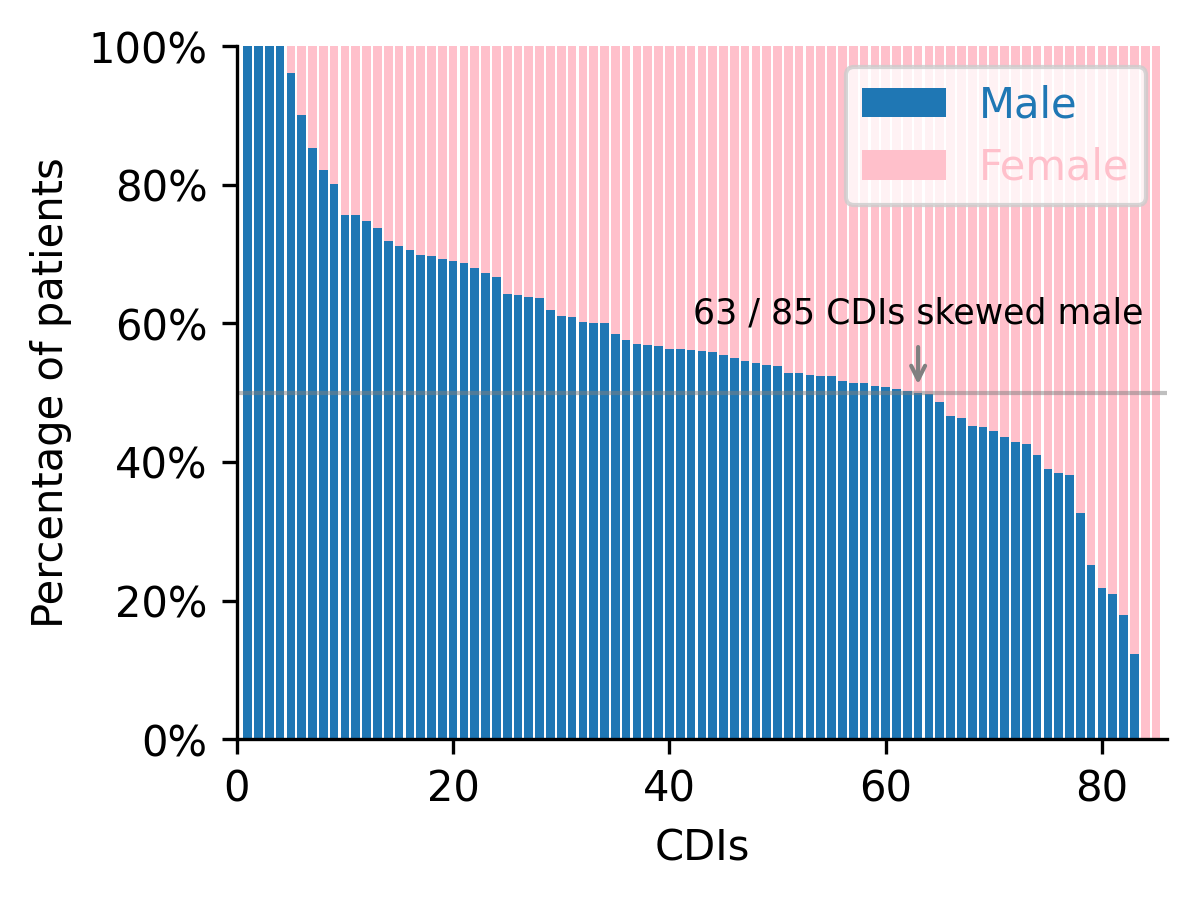

In [34]:
frac_male = male / (male + female)
frac_female = female / (male + female)
args = np.argsort(frac_male)[::-1]
frac_male = frac_male.values[args] * 100
frac_female = frac_female.values[args] * 100

# barplot showing frac_male and frac_female as stacked bars
plt.figure(figsize=(4, 3), dpi=300)

num_cdis = len(frac_male)
bar_positions = np.arange(num_cdis) + 1
plt.bar(bar_positions, frac_male, label="Male", color="C0")
plt.bar(bar_positions, frac_female, bottom=frac_male, label="Female", color="pink")
plt.axhline(50, color="gray", alpha=0.5, lw=1)

plt.xlabel("CDIs")
plt.ylabel("Percentage of patients")
plt.legend(labelcolor="linecolor")
# plt.xticks(np.arange(1, num_cdis + 1, num_cdis//3), np.arange(1, num_cdis + 1, num_cdis//3))
plt.xlim(left=0, right=num_cdis + 1)
plt.yticks(np.arange(0, 101, 20), [f"{t}%" for t in np.arange(0, 101, 20)])

# annotate the point where the two bars cross 50 percent
x_cross = np.where(frac_male <= frac_female)[0][0] + 1
plt.annotate(
    f"{x_cross} / {num_cdis} CDIs skewed male",
    (x_cross, 50),
    xytext=(x_cross, 60),
    ha="center",
    arrowprops=dict(arrowstyle="->", color="gray"),
    fontsize='small'
)

# Show the plot
plt.show()

### Overal study counts

In [ ]:
plt.figure(dpi=300)
x = df['num_total_corrected']
x = x[x > 0]
hist, bins, _ = plt.hist(x, bins=50)

# histogram on log scale.
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins, color='gray')
plt.xscale("log")
plt.xlabel('Number of patients')
plt.ylabel('Study count')
plt.show()

### Race ratios

In [ ]:
race_keys = ['num_white_corrected',	'num_black_corrected', 'num_latino_corrected', 'num_asian_corrected']
CENSUS_NUMS = {
    'White': 58.9,
    'Black': 13.6,
    'Latino': 19.1,
    'Asian': 6.3,
}
vals_dict = defaultdict(list)
for k in race_keys:
    vals = df[k][df[k].notnull() & ~(df[k] == 'Unk')]
    vals = [float(v[:-1]) for v in vals]
    vals_dict[k] = vals

# make boxplot
plt.figure(figsize=(4, 3), dpi=300)
# plt.boxplot(vals_dict.values(), labels=vals_dict.keys(), showfliers=False)
# add scatterplots
for i, (k, v) in enumerate(vals_dict.items()):
    kwargs = {}
    if i == len(vals_dict) - 1:
        kwargs['label'] = 'CDI patients'

    plt.plot(np.random.normal(i, 0.05, len(v)), v, 'o', alpha=0.5, color='C2', ms=2, **kwargs)
    plt.plot(i, np.median(v), 'o', color='C2', ms=3) #, ms=3)
    plt.errorbar(i, np.median(v), yerr=np.std(v) / np.sqrt(len(v)), color='C2', capsize=3) #, ms=3)

    if i == len(vals_dict) - 1:
        kwargs['label'] = 'US Census 2022'
    # plot census
    val = CENSUS_NUMS[list(CENSUS_NUMS.keys())[i]]
    plt.plot(i, val, 'o', color='black', ms=3, **kwargs) #, ms=3)


plt.legend()
plt.xticks(labels=['White', 'Black', 'Latino', 'Asian'], ticks=range(4))
plt.yticks(ticks=range(0, 100, 20), labels=[f'{t}%' for t in range(0, 100, 20)])
plt.ylabel("Percentage of patients")
plt.grid(axis='y', alpha=0.5)
plt.show()